In [1]:
#imports
import tensorflow as tf
print(tf.__version__)

import numpy as np
import matplotlib.pyplot as plt
# from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
# from tensorflow.keras.models import Model
import tensorflow_datasets as tfds

2.4.1


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())



[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14179283850747136243
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14674281152
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11535133864217633194
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [3]:
# Construct a tf.data.Dataset
(train_set, test_set), set_info = tfds.load('oxford_iiit_pet', split=['train','test'], shuffle_files=True, as_supervised=True, with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteT9S8W2/oxford_iiit_pet-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteT9S8W2/oxford_iiit_pet-test.tfrecord


Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


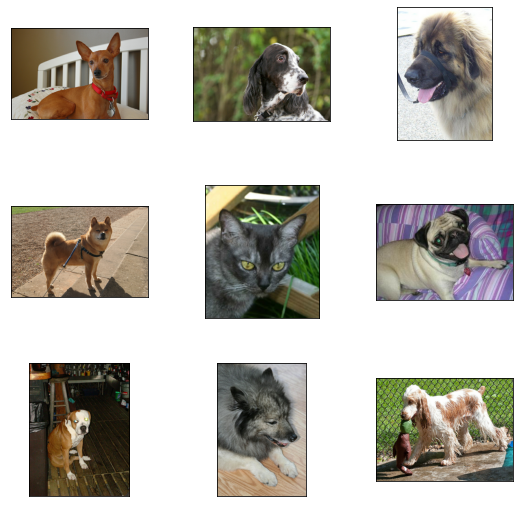

In [4]:
a = tfds.show_examples(train_set, set_info, image_key ="image")
# set_info

In [5]:
# Function that resizes images to 128x128 and then normalizes from uint8 to float32
input_shape = (128,128,3)
def resize_and_normalize(image, label):
  image = tf.image.resize(image, input_shape[:2])
  return tf.cast(image, tf.float32) / 255., label

In [6]:
# Training pipeline
train_set = train_set.map(resize_and_normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_set = train_set.cache()
# train_set = train_set.shuffle(set_info.splits['train'].num_examples)
train_set = train_set.shuffle(500)
train_set = train_set.batch(32)
train_set = train_set.prefetch(tf.data.experimental.AUTOTUNE)

In [7]:
# Testing pipeline
test_set = test_set.map(
    resize_and_normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_set = test_set.batch(32)
test_set = test_set.cache()
test_set = test_set.prefetch(tf.data.experimental.AUTOTUNE)
# test_set
# print(test_set)

In [37]:
model = tf.keras.Sequential()

model.add(tf.keras.Input(shape=input_shape))
# model.add(tf.keras.layers.Dropout(0.2))


model.add(tf.keras.layers.Conv2D(2, (3,3), activation='relu', padding="same"))
model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Conv2D(2, (3,3), activation='relu', padding="same"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((2,2)))
    
# model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Conv2D(8, (3,3), activation='relu', padding="same"))
model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Conv2D(8, (3,3), activation='relu', padding="same"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((2,2)))

# model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(37, activation='softmax'))

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)



Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 128, 128, 2)       56        
_________________________________________________________________
batch_normalization_16 (Batc (None, 128, 128, 2)       8         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 128, 128, 2)       38        
_________________________________________________________________
batch_normalization_17 (Batc (None, 128, 128, 2)       8         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 64, 64, 2)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 64, 64, 8)         152       
_________________________________________________________________
batch_normalization_18 (Batc (None, 64, 64, 8)        

In [38]:
result = model.fit(
    train_set,
    epochs=100,
    validation_data=test_set,
)

Epoch 1/100
115/115 [==============================] - 3s 18ms/step - loss: 3.9435 - sparse_categorical_accuracy: 0.0647 - val_loss: 9.2091 - val_sparse_categorical_accuracy: 0.0273
Epoch 2/100
115/115 [==============================] - 2s 15ms/step - loss: 2.3451 - sparse_categorical_accuracy: 0.3800 - val_loss: 5.9827 - val_sparse_categorical_accuracy: 0.0401
Epoch 3/100
115/115 [==============================] - 2s 15ms/step - loss: 1.0280 - sparse_categorical_accuracy: 0.7456 - val_loss: 6.1332 - val_sparse_categorical_accuracy: 0.0439
Epoch 4/100
115/115 [==============================] - 2s 15ms/step - loss: 0.1743 - sparse_categorical_accuracy: 0.9638 - val_loss: 5.3843 - val_sparse_categorical_accuracy: 0.0605
Epoch 5/100
115/115 [==============================] - 2s 16ms/step - loss: 0.0264 - sparse_categorical_accuracy: 0.9985 - val_loss: 4.8773 - val_sparse_categorical_accuracy: 0.0763
Epoch 6/100
115/115 [==============================] - 2s 16ms/step - loss: 0.0067 - spars

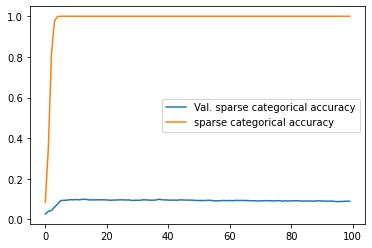

In [39]:
import matplotlib.pyplot as plt

# Plot the prediction accuracy
plt.plot(result.history["val_sparse_categorical_accuracy"], label="Val. sparse categorical accuracy")
plt.plot(result.history["sparse_categorical_accuracy"], label="sparse categorical accuracy")

# plt.plot(result.history["val_loss"], label="Val loss")
plt.legend()

In [40]:
val_acc = result.history["val_sparse_categorical_accuracy"][95:]
val_acc_avg=0
for entry in val_acc:
    val_acc_avg += entry/len(val_acc)
    
train_acc = result.history["sparse_categorical_accuracy"][95:]
train_acc_avg=0
for entry in train_acc:
    train_acc_avg += entry/len(train_acc)
    
print("Train acc: " + str(train_acc_avg) + "  Val acc: " + str(val_acc_avg))

Train acc: 1.0  Val acc: 0.08885254710912704


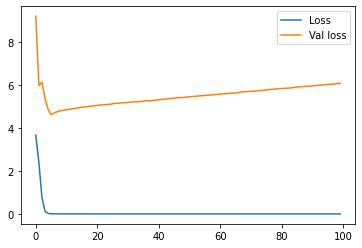

In [41]:
# Plot the loss
plt.plot(result.history["loss"], label="Loss")
plt.plot(result.history["val_loss"], label="Val loss")
plt.legend()

In [42]:
 std_batchnorm_loss = result.history["loss"]
 std_batchnorm_val_loss = result.history["val_loss"]

Text(0.5, 1.0, 'Training loss per epoch')

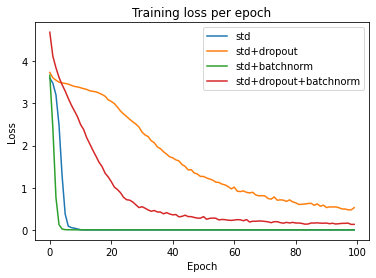

In [51]:
#plot loss
std_loss
std_dropout_loss

plt.plot(std_loss, label="std")
plt.plot(std_dropout_loss, label="std+dropout")
plt.plot(std_batchnorm_loss, label="std+batchnorm")
plt.plot(std_dropout_batchnorm_loss, label="std+dropout+batchnorm")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training loss per epoch")

Text(0.5, 1.0, 'Validation loss per epoch')

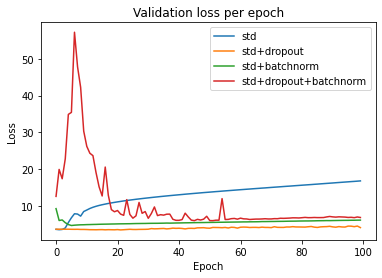

In [50]:
#plot val losses
std_val_loss
std_dropout_val_loss

plt.plot(std_val_loss, label="std")
plt.plot(std_dropout_val_loss, label="std+dropout")
plt.plot(std_batchnorm_val_loss, label="std+batchnorm")
plt.plot(std_dropout_batchnorm_val_loss, label="std+dropout+batchnorm")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation loss per epoch")